In [1]:
%load_ext autoreload

In [2]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=FutureWarning)
simplefilter(action="ignore", category=UserWarning)
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

import loadBar
from csv_parser import CSVParser
from globals import RESOURCE_FOLDER, STEPSIZES, OUTPUT_WINDOW, INPUT_WINDOW, OUTPUT_FORECAST, DELETEABLE_COLUMNS, ONE_HOT_COLUMNS
from markovSquares import apply_markov
from feature_engineer import FeatureEngineer
from exploring_data_functions import *

from searoutePointFinder import fill_with_proximity


In [3]:
parser = CSVParser(RESOURCE_FOLDER)
index_data = parser.retrieve_training_data()



In [4]:

index_data.set_index("time", inplace=True)

In [5]:
def resampler(df, sorting_column, freq):
    unique_ids = df[sorting_column].unique()
    final_df = pd.DataFrame()
    partial_list = []

    for i in range(len(unique_ids)):
        loadBar.load_bar(len(unique_ids),i+1)
        resample_partial = df[df[sorting_column] == unique_ids[i]].resample(freq).last()

        resample_partial = fill_with_proximity(resample_partial)
        partial_list.append(resample_partial)

    for chunk in partial_list:
        final_df = pd.concat([final_df,chunk])
    
    return final_df

print(index_data)
resampled_data_20min = resampler(index_data, "vesselId", "20min")

resampled_data_20min.to_csv("../../Project materials(1)/data_resampled_20min.csv")

                       cog   sog  rot  heading  navstat  latitude  longitude  \
time                                                                           
2024-01-01 00:00:25  284.0   0.7    0       88        0 -34.74370  -57.85130   
2024-01-01 00:00:36  109.6   0.0   -6      347        1   8.89440  -79.47939   
2024-01-01 00:01:45  111.0  11.0    0      112        0  39.19065  -76.47567   
2024-01-01 00:03:11   96.4   0.0    0      142        1 -34.41189  151.02067   
2024-01-01 00:03:51  214.0  19.7    0      215        0  35.88379   -5.91636   
...                    ...   ...  ...      ...      ...       ...        ...   
2024-05-07 23:59:07  359.1  13.4    0        1        0  52.19131   -5.82223   
2024-05-07 23:59:08   12.3  17.1    0       13        0  38.96142  -12.00502   
2024-05-07 23:59:08  269.8  14.9   -1      270        0  49.71372   -5.22042   
2024-05-07 23:59:08    8.0  18.7    0        6        0  38.27895   10.78280   
2024-05-07 23:59:08  336.0  14.3    5   

In [6]:
total_df = pd.read_csv(RESOURCE_FOLDER+"/data_resampled_20min.csv")
total_df["time"] = pd.to_datetime(total_df['time'])

In [7]:
feature_engineering_functions = [categorize_navstat,numerize_UN_LOCODE, numerize_ISO] #, daystoETAparsed, categorize_rot #apply_markov


feature_engineer = FeatureEngineer(total_df)
feature_engineer.apply_features(feature_engineering_functions)
total_df = feature_engineer.get_dataframe()

total_df.set_index("time", inplace=True)

In [8]:
print(total_df.shape)

(5899721, 17)


In [9]:

one_hot_columns = ONE_HOT_COLUMNS
total_df = pd.get_dummies(total_df, columns=one_hot_columns, drop_first=False)

In [10]:
print(total_df.head())

                       cog  sog  rot  heading  navstat   latitude  longitude  \
time                                                                           
2024-01-01 00:00:00  284.0  0.7  0.0     88.0      0.0 -34.743700 -57.851300   
2024-01-01 00:20:00  284.0  0.7  0.0     88.0      0.0 -34.627229 -57.966135   
2024-01-01 00:40:00  284.0  0.7  0.0     88.0      0.0 -34.510757 -58.080969   
2024-01-01 01:00:00  284.0  0.7  0.0     88.0      0.0 -34.394286 -58.195804   
2024-01-01 01:20:00  284.0  0.7  0.0     88.0      0.0 -34.277814 -58.310639   

                                     vesselId                    portId  \
time                                                                      
2024-01-01 00:00:00  61e9f3a8b937134a3c4bfdf7  61d371c43aeaecc07011a37f   
2024-01-01 00:20:00  61e9f3a8b937134a3c4bfdf7  61d371c43aeaecc07011a37f   
2024-01-01 00:40:00  61e9f3a8b937134a3c4bfdf7  61d371c43aeaecc07011a37f   
2024-01-01 01:00:00  61e9f3a8b937134a3c4bfdf7  61d371c43aeaecc07

In [27]:
#Make time series into supervised problem

# 1 = 20 minutes
# 3 = 1 hour
# 18 = 6 hours
# 72 = 24 hours
# 144 = 2 days
# 216 = 3 days
# 288 = 4 days
# 360 = 5 days



def make_supervised(df, forecast_columns, sorting_column, input_window=1, output_window=1, stepsize=1, verbose=True):
    """
    Converts a multivariate time series dataframe into a supervised learning problem.
    
    Parameters:
    df (pd.DataFrame): The original dataframe with time series data.
    forecast_columns (list): A list of column names to forecast.
    input_window (int): The number of past observations to use as features.
    output_window (int): The number of steps to forecast into the future.
    
    Returns:
    pd.DataFrame: A new dataframe with supervised learning format.
    """
    

    df_new = pd.DataFrame()
    #Put in a for loop here where you iterate over all IDs, to make sure things get correct
    unique_sorts = df[sorting_column].unique()

    #Iterate through all IDs
    if verbose:
        print("Creating supervised data")
    for i, sorts in enumerate(unique_sorts):
        if verbose:
            loadBar.load_bar(len(unique_sorts),i+1)
        sort_df = df[df[sorting_column] == sorts]
        for start in range(stepsize):
            sort_df = sort_df.iloc[start::stepsize]
        
            df_supervised = supervise_single_vessel_df(sort_df, forecast_columns, input_window, output_window)
        
            df_new = pd.concat([df_new, df_supervised])
    
    return df_new


def supervise_single_vessel_df(sort_df, forecast_columns, input_window=1, output_window=1):
    df_supervised = pd.DataFrame()
    other_cols = [col for col in sort_df.columns if col not in forecast_columns]

    #Iterate through all columns for input features
    for col in forecast_columns: 
        for i in range(input_window, 0, -1):
            df_supervised[f"{col}_t-{i}"] = sort_df[col].shift(i)
        
        df_supervised[f"{col}_t"] = sort_df[col]
        

    # Create columns for forecast (target) with forward shift
    for col in forecast_columns:
        for j in range(output_window, 0,-1):
            df_supervised[f"{col}_t+{j}"] = sort_df[col].shift(-j)

    df_supervised = df_supervised.dropna()

    df_supervised[other_cols] = sort_df[other_cols]

    return df_supervised


def supervise_on_stepsize(df, stepsize, output_forecast, sorting_column, input_window, output_window):
    

    forecast_columns = ["lat", "lon"]
    supervised_df = make_supervised(df, forecast_columns, sorting_column, input_window, output_window)
    supervised_df.to_csv(f"../../build_resources/supervised_{stepsize}_input_{input_window}_output_{output_window}.csv")
    return supervised_df

In [12]:
total_df = make_supervised(total_df, OUTPUT_FORECAST, "vesselId", input_window=INPUT_WINDOW, output_window=OUTPUT_WINDOW)

Creating supervised data
[====================] 100.0% complete


In [13]:
total_df = total_df.drop(DELETEABLE_COLUMNS, axis=1)

In [14]:


#Sorting columns
def sort_columns(df):
    selected_columns = df.filter(regex=r'_t$|_t\+|_t-')
    non_selected_columns = df.drop(selected_columns.columns, axis=1)
    # Extract suffixes and assign _t as _t0
    columns_with_suffix = []
    for col in selected_columns.columns:
        match = re.search(r"_t([+-]?\d*)$", col)
        # If there's no number after _t, treat it as _t0
        suffix = int(match.group(1)) if match.group(1) else 0
        columns_with_suffix.append((col, suffix))
    
    # Sort by suffix value (ascending)
    sorted_t_columns = [col for col, _ in sorted(columns_with_suffix, key=lambda x: x[1])]
    
    # Reorder dataframe columns
    return df[sorted_t_columns+non_selected_columns.columns.tolist()]

total_df = total_df.dropna()
print(len(total_df))
total_df = total_df.sort_index(ascending = True)
total_df=sort_columns(total_df)

print(total_df)



5896285
                     latitude_t-4  longitude_t-4  sog_t-4  cog_t-4  \
time                                                                 
2024-01-01 01:20:00     -34.74370      -57.85130      0.7    284.0   
2024-01-01 01:20:00      44.40593        8.88505      0.0     11.5   
2024-01-01 01:20:00      52.32413        2.10535      1.2    320.0   
2024-01-01 01:20:00      33.63707     -118.23330      9.9    162.8   
2024-01-01 01:20:00      53.57537        8.56014      0.0    271.5   
...                           ...            ...      ...      ...   
2024-05-07 23:20:00      43.58091       10.30400      0.0    352.5   
2024-05-07 23:20:00       1.17829      103.75309      0.2    224.6   
2024-05-07 23:20:00      59.57721       21.54090     14.7    296.3   
2024-05-07 23:20:00      10.63965      106.76226      0.0    113.6   
2024-05-07 23:20:00      36.86324     -122.49700      7.8    342.0   

                     latitude_t-3  longitude_t-3  sog_t-3  cog_t-3  \
time       

In [15]:


def train_test_split(df, perc1, perc2, output_window):
    y_list = []
    for j in range(output_window):
        for col in OUTPUT_FORECAST:
            y_list.append(f"{col}_t+{j+1}")
    ys = df[y_list]
    Xs = df.drop(columns = y_list)

    X_train = Xs.iloc[:int(np.round(Xs.shape[0]*perc1)),:]
    y_train = ys.iloc[:int(np.round(Xs.shape[0]*perc1)),:]
    X_val = Xs.iloc[int(np.round(Xs.shape[0]*perc1)):int(np.round(Xs.shape[0]*perc2)),:]
    y_val = ys.iloc[int(np.round(Xs.shape[0]*perc1)):int(np.round(Xs.shape[0]*perc2)),:]
    X_test = Xs.iloc[int(np.round(Xs.shape[0]*perc2)):,:]
    y_test = ys.iloc[int(np.round(Xs.shape[0]*perc2)):,:]

    return X_train, y_train, X_val, y_val, X_test, y_test



X_train, y_train, X_val, y_val, X_test, y_test = train_test_split(total_df, 0.85, 0.99, OUTPUT_WINDOW)



In [16]:
def evaluate(stepsize, preds, y_val):
    print("/"+"-"*50+"\\")
    print("Evaluating model with stepsize", stepsize)

    results = {
        "MAE": mean_absolute_error(y_val, preds),
        "MSE": np.square(np.subtract(y_val,preds)).mean(),
        "R2 Score": r2_score(y_val, preds),
        "RMSE": np.sqrt(np.square(np.subtract(y_val,preds)).mean())
    }

    for metric, value in results.items():
        print(f"{metric}: {value}")
    print("\\"+"-"*50+"/")



In [ ]:
# #Tuning params
# # We need to use XGB

# # Define model with a high num_boost_round
# model = xgb.XGBRFRegressor(
#     objective="reg:squarederror",
#     tree_method="hist",  # or "hist" if not using GPU
#     n_jobs=-1
# )

# # Define parameter grid
# param_grid = {
#     "max_depth": [3, 5, 7],
#     "learning_rate": [1],
#     "subsample": [0.6, 0.8, 1.0],
#     "colsample_bynode": [0.4, 0.6, 0.8],
#     "num_parallel_tree": [50, 100, 200]
# }

# # Use TimeSeriesSplit for time series cross-validation
# tscv = TimeSeriesSplit(n_splits=10)

# # Set early stopping and validation set in fit parameters
# fit_params = {
#     "eval_set": [(X_val, y_val)],  # Validation set to monitor performance
#     "verbose": 1
# }

# # RandomizedSearchCV with early stopping
# random_search = RandomizedSearchCV(
#     estimator=model,
#     param_distributions=param_grid,
#     n_iter=20,  # Number of sampled parameter combinations
#     scoring="neg_mean_squared_error",
#     cv=tscv,
#     verbose=1,
#     random_state=42
# )

# # Fit with early stopping
# random_search.fit(X_train, y_train, **fit_params)

# # Output best parameters and number of boosting rounds
# best_params = random_search.best_params_
# best_num_boost_round = model.get_booster().best_iteration  # Retrieve best boosting rounds
# print("Best parameters:", best_params)
# print("Best num_boost_round:", best_num_boost_round)


In [17]:
fitting_columns=X_train.columns.to_list()
fitting_types=X_train.dtypes.to_dict()

In [28]:

print(X_train)



dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest_X = xgb.DMatrix(X_test)

params = {"objective": "reg:squarederror",
            "max_depth": 7,
            "booster": "gbtree",
            "tree-method": "gpu_hist",
            "colsample_bynode": 0.4,
            "num_parallel_tree": 50,
            "subsample": 0.6,
            "seed": 42,
            "learning_rate": 1,
            #"n_estimators": 100,
            #"reg_alpha": 0.1,
            #"reg_lambda": 0.1,
            #"n_jobs": -1,
            "verbosity": 1
            }

#Subsample was 0.8, num-parallel tree was 100, colsample-bynode was 0.5 and max-depth was 5. Before tuning. 

#After first round of tuning we got sumbsample was 0.6, num-parallel tree was 50, colsample-bynode was 0.4 and max-depth was 7. Before tuning. 

#After secnd rund we gt subsampe 0,4 , csampe-bynde 0,4 num-paraee tree 50 and max-depth 10
num_boost_round = 30

#Tried 50, but that stagnated quickly. So reducing again to 30.  


early_stopping_rounds = 3

print(dtrain)

model = xgb.train(params, dtrain, num_boost_round, evals=[(dval, "validation")], 
                  early_stopping_rounds=early_stopping_rounds, verbose_eval=True)


preds = model.predict(dtest_X)



                     latitude_t-4  longitude_t-4  sog_t-4  cog_t-4  \
time                                                                 
2024-01-01 01:20:00    -34.743700     -57.851300      0.7    284.0   
2024-01-01 01:20:00     44.405930       8.885050      0.0     11.5   
2024-01-01 01:20:00     52.324130       2.105350      1.2    320.0   
2024-01-01 01:20:00     33.637070    -118.233300      9.9    162.8   
2024-01-01 01:20:00     53.575370       8.560140      0.0    271.5   
...                           ...            ...      ...      ...   
2024-04-16 12:00:00    -27.288908      66.061437     15.8    212.0   
2024-04-16 12:00:00     12.038616     100.968795     16.9    244.6   
2024-04-16 12:00:00     41.638620     142.018250     16.3     87.0   
2024-04-16 12:00:00    -15.839077     -37.511589     15.7     62.5   
2024-04-16 12:00:00     54.244450       7.274670      1.5    135.4   

                     latitude_t-3  longitude_t-3  sog_t-3  cog_t-3  \
time               

In [29]:
def closest_n_min_mark(timestamp, n=1):
    timestamp = pd.to_datetime(timestamp)
    minutes = timestamp.minute
    closest_mark = round(minutes / (n*20)) * n*20
    if closest_mark == 60:
        rounded_timestamp = timestamp.replace(minute=0, second=0, microsecond=0) + pd.Timedelta(hours=1)
    else:
        rounded_timestamp = timestamp.replace(minute=closest_mark, second=0, microsecond=0)
    
    return rounded_timestamp

In [30]:
def shift_to_back(process_df):      
    for _, col in enumerate(OUTPUT_FORECAST):

        max_suffix_neg = 0
        max_suffix_pos = 0
        
        # Identify existing suffixes in the process_df for the current column
        while f"{col}_t-{max_suffix_neg+1}" in process_df.columns:
            max_suffix_neg += 1
        while f"{col}_t+{max_suffix_pos+1}" in process_df.columns:
            max_suffix_pos += 1
        for shift in range(max_suffix_neg - 1, -max_suffix_pos, -1):  # Start from max_suffix-1 down to 0
            if shift == 0:
                # Set the new predicted value as the most recent
                process_df[f"{col}_t"] = process_df[f"{col}_t+1"]
            elif shift == 1:
                # Shift the column
                process_df[f"{col}_t-{shift}"] = process_df[f"{col}_t"]
            elif shift > 1:
                # Shift the column
                process_df[f"{col}_t-{shift}"] = process_df[f"{col}_t-{shift - 1}"]
            else:
                process_df[f"{col}_t+{-shift}"] = process_df[f"{col}_t+{-shift + 1}"]

        for shift in range(1, max_suffix_pos+1):
            process_df = process_df.drop(columns=[f"{col}_t+{shift}"])
    
    return process_df


In [ ]:
#update_features=[apply_markov]

In [31]:
def predict_far_future(model, features, test_df,  forecast_columns):
    
    X_test = features.copy().iloc[-1:]
    preds = pd.DataFrame(columns=["vesselId", "approximate_time"])
    
    # Determine the furthest time in 20-minute intervals
    furthest_time = closest_n_min_mark(test_df["time"].max())
    current_time = closest_n_min_mark(X_test.index.max())
    
    # Generate the future time steps at 20-minute intervals
    future_steps = pd.date_range(start=current_time, end=furthest_time, freq='20min')
    
    for future_time in future_steps:
        y_pred = model.predict(xgb.DMatrix(X_test))

        new_row = pd.DataFrame({
            "vesselId": [test_df["vesselId"].iloc[0]],
            "approximate_time": [future_time]
        })
        for idx, col in enumerate(forecast_columns):
            new_row[f"{col}"] = y_pred[0, idx]  # Use the predicted value
        
        updateable_feature_engineer = FeatureEngineer(new_row)
        #updateable_feature_engineer.apply_features(update_features)
        #new_row = updateable_feature_engineer.get_dataframe()

        selected_columns = X_test.filter(regex=r'_t$|_t\+|_t-')
        non_selected_columns = X_test.drop(selected_columns.columns, axis=1)
        new_row[non_selected_columns.columns] = X_test[non_selected_columns.columns].iloc[0]
        
        
        preds = pd.concat([preds, new_row], ignore_index=True)
        
        # Update X_test for the next iteration
        for idx, col in enumerate(forecast_columns):

            max_suffix = 0
            
            # Identify existing suffixes in the X_test for the current column
            while f"{col}_t-{max_suffix+1}" in X_test.columns:
                max_suffix += 1
            for shift in range(max_suffix - 1, -1, -1):  # Start from max_suffix-1 down to 0
                if shift == 0:
                    # Set the new predicted value as the most recent
                    X_test[f"{col}_t"] = y_pred[0, idx]
                elif shift == 1:
                    # Shift the column
                    X_test[f"{col}_t-{shift}"] = X_test[f"{col}_t"]
                else:
                    # Shift the column
                    X_test[f"{col}_t-{shift}"] = X_test[f"{col}_t-{shift - 1}"]
    
    return preds


csv_parser = CSVParser(folderpath="../../Project materials(1)")

test_df = csv_parser.retrieve_test_data()




In [32]:
def add_missing_columns(b, columns, dtypes):
    """
    Add missing columns to DataFrame b based on provided column names and data types.

    Parameters:
        b (pd.DataFrame): The target DataFrame to modify.
        columns (list): List of column names that should be present.
        dtypes (dict): Dictionary of column names and their desired data types.

    Returns:
        pd.DataFrame: The modified DataFrame b with missing columns added.
    """
    for col in columns:
        if col not in b.columns:
            # Determine the default value based on the type
            if pd.api.types.is_numeric_dtype(dtypes[col]):
                b[col] = 0  # Fill numeric columns with 0
            elif pd.api.types.is_bool_dtype(dtypes[col]):
                b[col] = False  # Fill boolean columns with False
            elif pd.api.types.is_datetime64_any_dtype(dtypes[col]):
                b[col] = pd.NaT  # Fill datetime columns with NaT (Not a Time)
            else:
                b[col] = 0  # Default for any other type, can customize as needed
            b[col] = b[col].astype(dtypes[col])
    
    b=b[columns]

    return b

In [33]:
def preprocess(latest_features, feature_engineering_functions):

    feature_engineer = FeatureEngineer(latest_features)
    feature_engineer.apply_features(feature_engineering_functions)
    latest_features = feature_engineer.get_dataframe()
    latest_features = pd.get_dummies(latest_features, columns=ONE_HOT_COLUMNS, drop_first=False)
    
    latest_features = make_supervised(latest_features, OUTPUT_FORECAST, "vesselId" , INPUT_WINDOW, OUTPUT_WINDOW, verbose=False)
    latest_features = shift_to_back(latest_features)
    latest_features = latest_features.dropna()
    latest_features = latest_features.drop(DELETEABLE_COLUMNS, axis=1)
    latest_features = sort_columns(latest_features)

    
    latest_features=add_missing_columns(latest_features, fitting_columns, fitting_types)
    
    return latest_features

In [34]:
def predict_times(model,total_df,test_df):
    unique_sorts = test_df["vesselId"].unique()
    preds_df = pd.DataFrame()
    result = pd.DataFrame()

    for sorts in unique_sorts:
        latest_features=total_df[total_df["vesselId"] == sorts]
        test_by_vessel_df = test_df[test_df["vesselId"] == sorts]

        latest_features = preprocess(latest_features, feature_engineering_functions)

        preds = predict_far_future(model, latest_features, test_by_vessel_df, OUTPUT_FORECAST)
        preds_df = pd.concat([preds_df, preds])
    
    for test in test_df.iterrows():
        test=pd.Series(test[1])
        new_row = pd.DataFrame()
        new_row=preds_df[
            (preds_df["vesselId"] == test["vesselId"]) & 
            (preds_df["approximate_time"] == closest_n_min_mark(test["time"]))
            ][["latitude", "longitude"]]
        new_row["ID"] = test["ID"]
        new_row["time"] = test["time"]
        
        result = pd.concat([result, new_row])
    result["latitude_predicted"] = result["latitude"]
    result["longitude_predicted"] = result["longitude"]

    return result[["ID","longitude_predicted","latitude_predicted"]]

print(test_df)
total_df = pd.read_csv("../../Project materials(1)/data_resampled_20min.csv")
total_df["time"] = pd.to_datetime(total_df['time'])
total_df.set_index("time", inplace=True)
print(total_df.head())
result_df = predict_times(model, total_df, test_df)
print(result_df)

          ID                  vesselId                time  scaling_factor
0          0  61e9f3aeb937134a3c4bfe3d 2024-05-08 00:03:16             0.3
1          1  61e9f473b937134a3c4c02df 2024-05-08 00:06:17             0.3
2          2  61e9f469b937134a3c4c029b 2024-05-08 00:10:02             0.3
3          3  61e9f45bb937134a3c4c0221 2024-05-08 00:10:34             0.3
4          4  61e9f38eb937134a3c4bfd8d 2024-05-08 00:12:27             0.3
...      ...                       ...                 ...             ...
51734  51734  61e9f3a8b937134a3c4bfdf3 2024-05-12 23:59:58             0.1
51735  51735  61e9f3b4b937134a3c4bfe77 2024-05-12 23:59:58             0.1
51736  51736  61e9f46cb937134a3c4c02b7 2024-05-12 23:59:58             0.1
51737  51737  61e9f465b937134a3c4c0269 2024-05-12 23:59:58             0.1
51738  51738  61e9f3adb937134a3c4bfe39 2024-05-12 23:59:58             0.1

[51739 rows x 4 columns]
                       cog  sog  rot  heading  navstat   latitude  longitu

/home/susan-palencia/Documents/Maskinlæring/OceanWarlock/src/exploring_data_functions.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toy_data["navstat_cat"] = np.where(toy_data["navstat"].isin(movement_values), "moving","not_moving")
/home/susan-palencia/Documents/Maskinlæring/OceanWarlock/src/feature_engineer.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[new_feature.name] = new_feature
/home/susan-palencia/Documents/Maskinlæring/OceanWarlock/src/feature_engineer.py:20: SettingWithCopyW

         ID  longitude_predicted  latitude_predicted
2         0           -81.885178           31.315664
2         1           120.193581           14.909541
2         2            10.831986           38.329578
2         3           172.317917          -43.167347
3         4            -6.647139           48.476124
...     ...                  ...                 ...
1088  51734           -78.885704           25.810856
1185  51735           144.097977           42.474056
1024  51736           141.800781           35.794716
375   51737            22.236437           59.462101
362   51738            10.041529           56.187820

[51739 rows x 3 columns]


In [35]:
#turn results into a csv file
result_df.to_csv("../../Project materials(1)/results.csv", index=False)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

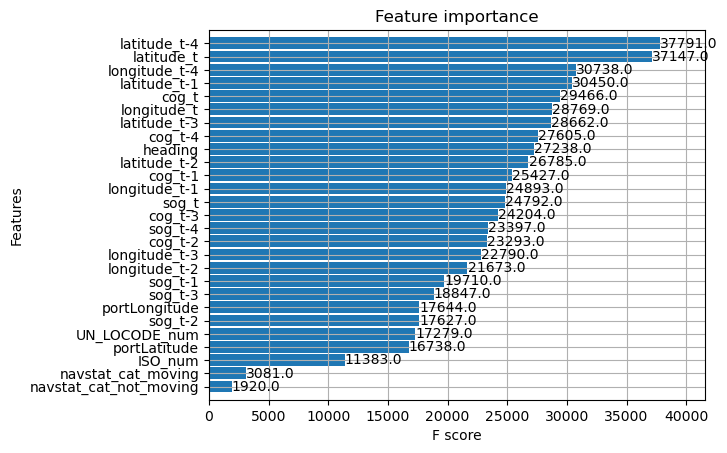

In [36]:
plot_importance(model, height=0.9)

### First model:
Included navstat and etaParsed

Timewindow: (3,2)

MAE: 0.8521843262281953 

MSE: longitude_t+1    21.225563

latitude_t+1      1.993130

longitude_t+2    38.471488

latitude_t+2      3.840146

dtype: float64

R2 Score: 0.9958523607729776

RMSE: longitude_t+1    4.607121

latitude_t+1     1.411783

longitude_t+2    6.202539

latitude_t+2     1.959629

dtype: float64


### Second model:

Added cog, rot and heading to target features.

Timewindow: (3,2)

MAE: 7.198335594601071
MSE: latitude_t+1        1.980426
longitude_t+1      21.577318
cog_t+1          1820.208937
rot_t+1            92.532501
heading_t+1      1172.604934
latitude_t+2        3.813640
longitude_t+2      39.218475
cog_t+2          2370.325440
rot_t+2           107.991661
heading_t+2      1769.347459
dtype: float64
R2 Score: 0.8826565909012996
RMSE: latitude_t+1      1.407276
longitude_t+1     4.645139
cog_t+1          42.663907
rot_t+1           9.619382
heading_t+1      34.243320
latitude_t+2      1.952854
longitude_t+2     6.262466
cog_t+2          48.685988
rot_t+2          10.391904
heading_t+2      42.063612
dtype: float64


## Third model:

Added Navstat again, but this time categorical. Also made rot categorical. This time we did not predict future values of other things than long and lat. Think we will predict future values of other things again.

Timewindow: (4,1)

Kaggle: 174.1591



## Fourth Model

Got rid of rot_cat, and put in tuned hyperparameters. We think It may be confused about time window, because the model interpretation does not make sense. We will will reduce the time window for the next model.

Timewindow: (8,1)

Kaggle: 243.6678

 ## Fourth Model

 Changed timewindow to 2,1., and put in tuned hyperparameters. Chose to not use 50 boosting rounds.

 Kaggle 177

 ## Fifth Model

 Changed timewindow to 1,1. Used 30 boosting rounds.

 Kaggle 190

 ## Sixth Model

 Changed timewind t 4,1 Used 30 boosting rounds

 Kaggle 171

## Seventh mde

Added Markv Did nt wrk S we wi nt add it anymre

Kagge 174

## Eight mde

Added new hyperparams and new navstat.

This may be because f d hyperparams 

Kagge 204

## Ninth mde

Gt rid f d hyperparams Did nt ike new navstat r new feature engineering 

Kagge 190 